In [2]:
# Import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from cartopy import crs as ccrs
from datetime import datetime
from pathlib import Path
import fsspec

(1) Adapt the code from class that reads GHCN Daily Data from Amazon Web Services and write a function that will download the station you want (called with a GHCN station ID), and calculate the all time record high and low and the normal (mean) high and low temperature for the 1991-2020 period for the desired station and returns a pandas data frame with the columns ['record_min_temp', average_min_temp', 'average_max_temp', record_max_temp']. Write a code that can call this function and successfully demonstrate that it works.

In [31]:
# Load in the appropriate txt files
S3_STATIONS_TXT   = "s3://noaa-ghcn-pds/ghcnd-stations.txt"
S3_INVENTORY_TXT  = "s3://noaa-ghcn-pds/ghcnd-inventory.txt"
S3_BY_STATION     = "s3://noaa-ghcn-pds/csv/by_station/{id}.csv"
STOR = {"anon": True}

colspecs = [(0,11),(12,20),(21,30),(31,37),(38,40),(41,71),(72,75),(76,79),(80,85)]
names = ['ID','LATITUDE','LONGITUDE','ELEVATION','STATE','NAME','GSN_FLAG','HCN_CRN_FLAG','WMO_ID']

stations = pd.read_fwf(S3_STATIONS_TXT, colspecs=colspecs, names=names, dtype={'ID':str,'STATE':str,'WMO_ID':str}, storage_options=STOR)
stations['NAME'] = stations['NAME'].str.strip(); stations['STATE'] = stations['STATE'].fillna('').str.strip()

inventory = pd.read_csv(
    S3_INVENTORY_TXT, sep=r'\s+', names=['ID','LAT','LON','ELEMENT','FIRSTYEAR','LASTYEAR'],
    dtype={'ID':str,'ELEMENT':str,'FIRSTYEAR':int,'LASTYEAR':int}, engine='python', storage_options=STOR
)

stations.head(), inventory.head()

(            ID  LATITUDE  LONGITUDE  ELEVATION STATE                   NAME  \
 0  ACW00011604   17.1167   -61.7833       10.1        ST JOHNS COOLIDGE FLD   
 1  ACW00011647   17.1333   -61.7833       19.2                     ST JOHNS   
 2  AE000041196   25.3330    55.5170       34.0          SHARJAH INTER. AIRP   
 3  AEM00041194   25.2550    55.3640       10.4                   DUBAI INTL   
 4  AEM00041217   24.4330    54.6510       26.8               ABU DHABI INTL   
 
   GSN_FLAG HCN_CRN_FLAG WMO_ID  
 0      NaN          NaN    NaN  
 1      NaN          NaN    NaN  
 2      GSN          NaN  41196  
 3      NaN          NaN  41194  
 4      NaN          NaN  41217  ,
             ID      LAT      LON ELEMENT  FIRSTYEAR  LASTYEAR
 0  ACW00011604  17.1167 -61.7833    TMAX       1949      1949
 1  ACW00011604  17.1167 -61.7833    TMIN       1949      1949
 2  ACW00011604  17.1167 -61.7833    PRCP       1949      1949
 3  ACW00011604  17.1167 -61.7833    SNOW       1949      194

In [32]:
# Identify stations in Indiana that have at least 30 years of data
coverage = (inventory.groupby('ID', as_index=False)
                    .agg(first=('FIRSTYEAR','min'), last=('LASTYEAR','max'))
                    .assign(years=lambda d: d['last'] - d['first'] + 1))

ind = (stations.loc[stations['STATE']=='IN', ['ID','NAME','STATE','LATITUDE','LONGITUDE','ELEVATION']]
              .merge(coverage, on='ID', how='inner'))
ind30 = ind[ind['years']>=30].copy()
ind30.sort_values(['years','ID'], ascending=[False, True]).head(12)

,ID,NAME,STATE,LATITUDE,LONGITUDE,ELEVATION,first,last,years
2017,USW00093823,TERRE HAUTE CAA AP,IN,39.4500,-87.3000,175.3,1875,2025,151
1852,USC00126001,MT VERNON,IN,37.9286,-87.8956,108.8,1888,2025,138
1816,USC00125117,LOGANSPORT CICOTT ST,IN,40.7478,-86.3878,182.9,1891,2025,135
1821,USC00125237,MADISON SEWAGE PLT,IN,38.7369,-85.3942,140.2,1892,2025,134
1620,USC00120200,ANGOLA,IN,41.6639,-85.0183,310.9,1893,2025,133
1669,USC00121747,COLUMBUS,IN,39.1661,-85.9228,185.6,1893,2025,133
1712,USC00122825,FARMLAND 5 NNW,IN,40.2539,-85.1483,294.1,1893,2025,133
1823,USC00125337,MARION 2 N,IN,40.5800,-85.6586,240.8,1893,2025,133
1879,USC00126580,OOLITIC PURDUE EX FM,IN,38.8886,-86.5517,197.8,1893,2025,133
1902,USC00127125,1 WSW PRINCETON,IN,38.3517,-87.5925,137.2,1893,2025,133


In [33]:
# Take the file for the Purdue station
Purdue = 's3://noaa-ghcn-pds/csv/by_station/USC00126580.csv'

In [38]:
# Write and call a function that returns the record max temperature, record min temperature, 
# average max temperature, and average min temperature in a pandas dataframe by calendar day.
# Only take measurements for the 1991-2020 period and do not include leap days

def load_station_daily(url: str) -> pd.DataFrame:
    df = pd.read_csv(url, storage_options = STOR, dtype = {'ID': str, 'ELEMENT': str}, parse_dates = ['DATE'])
    df['DATA_VALUE'] = df['DATA_VALUE'].replace(-9999, np.nan)
    wide = (df.pivot_table(index = ['ID', 'DATE'], columns = 'ELEMENT', values = 'DATA_VALUE', aggfunc = 'first').reset_index())
    for c in ('TMAX', 'TMIN', 'TAVG'):
        if c in wide: wide[c] = wide[c] / 10.0
    wide = wide[(wide['DATE'].dt.year >= 1991) & (wide['DATE'].dt.year <= 2020)]
    wide['month'] = wide['DATE'].dt.month
    wide['day'] = wide['DATE'].dt.day
    wide = wide[~((wide['month'] == 2) & (wide['day'] == 29))]
    # Group by calendar day and compute the record & average temperatures
    summary = wide.groupby(['month', 'day']).agg(
        record_max_temp = ('TMAX', 'max'),
        record_min_temp = ('TMIN', 'min'),
        avg_max_temp = ('TMAX', 'mean'),
        avg_min_temp = ('TMIN', 'mean')
    ).reset_index()

    # Create a 'date' column to know which calendar day each value belongs to.
    summary['date'] = pd.to_datetime({
    'year': 1991,
    'month': summary['month'],
    'day': summary['day']
    })
    
    #  Set up a pandas dataframe and return it when the function is called
    summary = summary[['date', 'record_max_temp', 'record_min_temp', 'avg_max_temp', 'avg_min_temp']].sort_values('date').reset_index(drop = True)
    return summary

frames = []
w = load_station_daily(Purdue)
frames.append(w); print(w.shape)

daily = pd.concat(frames, ignore_index=True)
daily.head()

/tmp/ipykernel_58829/2036283559.py:6: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, storage_options = STOR, dtype = {'ID': str, 'ELEMENT': str}, parse_dates = ['DATE'])


(365, 5)


,date,record_max_temp,record_min_temp,avg_max_temp,avg_min_temp
0,1991-01-01,17.8,-20.0,4.950000,-4.120000
1,1991-01-02,16.1,-22.2,4.400000,-6.310000
2,1991-01-03,19.4,-22.2,4.730000,-4.273333
3,1991-01-04,18.9,-17.8,5.203333,-5.193333
4,1991-01-05,19.4,-18.3,4.280000,-5.736667


(2) Develop a plot (using matplotlib) that displays for the city of choice a plot showing the record, average, and actual high and low temperatures for that year and city.

Text(0.5, 1.0, 'Temperature Seasonality for West Lafayette, IN \n1991-2020')

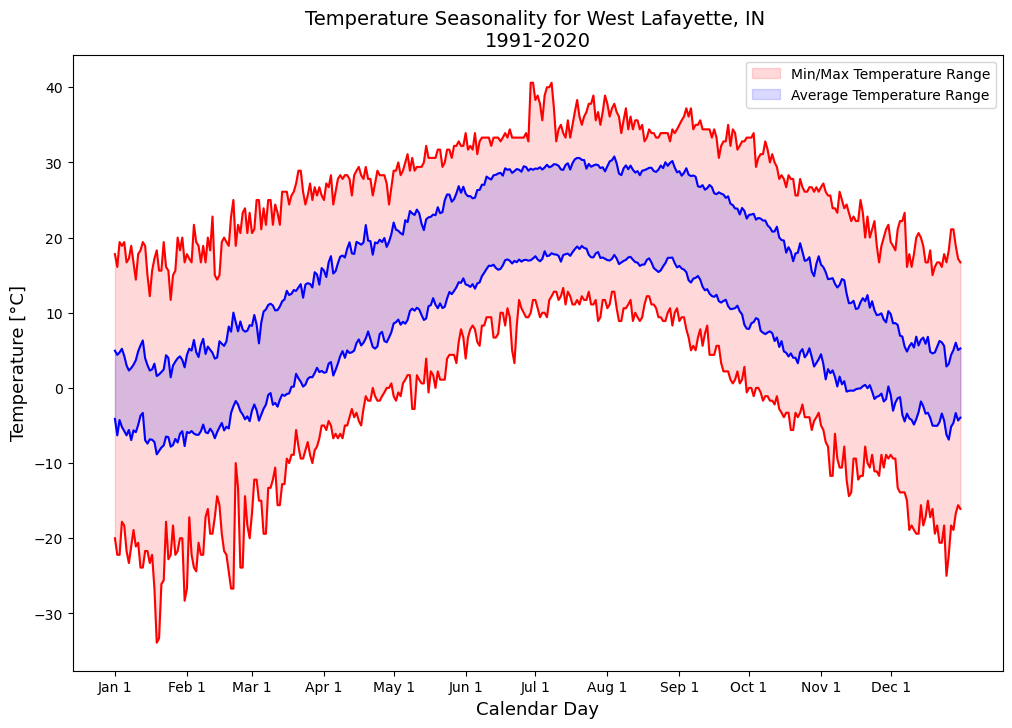

In [39]:
# Make a seasonality time series plot that plots the 4 time series in the daily dataframe
# Shade in the area between the min/max time series and the area between the average time series
days = np.arange(1, daily.shape[0] + 1)
maxT = daily['record_max_temp']
minT = daily['record_min_temp']
avg_maxT = daily['avg_max_temp']
avg_minT = daily['avg_min_temp']

plt.figure(figsize = (12,8))
plt.plot(days, maxT, color = 'red')
plt.plot(days, minT, color = 'red')
plt.plot(days, avg_maxT, color = 'blue')
plt.plot(days, avg_minT, color = 'blue')
plt.fill_between(days, minT, maxT, color='red', alpha=0.15, label='Min/Max Temperature Range')
plt.fill_between(days, avg_minT, avg_maxT, color='blue', alpha=0.15, label='Average Temperature Range')

month_starts = pd.date_range('1991-01-01', periods=12, freq='MS')
xtick_pos = month_starts.dayofyear.values  
xtick_labels = month_starts.strftime('%b 1') 

plt.legend()
plt.xticks(xtick_pos, xtick_labels)
plt.xlabel('Calendar Day', fontsize = 13)
plt.ylabel('Temperature [°C]', fontsize = 13)
plt.title('Temperature Seasonality for West Lafayette, IN \n1991-2020', fontsize = 14)